In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 876.6/876.6 kB 10.5 MB/s eta 0:00:00


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from ultralytics import YOLO

# بارگذاری مدل از پیش آموزش دیده YOLOv8
model = YOLO('yolov8n-cls.pt')

# اطمینان از اینکه مدل در حالت ارزیابی است
model.model.eval()

# غیرفعال کردن محاسبه گرادیان برای تمام پارامترها
#for param in model.model.parameters():
    #param.requires_grad = False

# بارگذاری و پیش‌پردازش تصویر
image_path = '/content/cat2.jpg'  # مسیر تصویر خود را اینجا وارد کنید
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Image not found at {image_path}")

#opencv load images in BGR format and should convert to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#change the image size to 224*224
image_resized = cv2.resize(image_rgb, (224, 224))

#1- Convert numpy image to pytorch
#2- Convert from (height, width, channels) to (channels, height, width) suitble for pytorch
#3- .unsqueeze(0) for addding new dimention to tensor (batch_size, channels, height, width)
#4-/ 255.0: مقادیر پیکسل‌ها از محدوده [0, 255] به محدوده [0, 1] نرمال‌سازی می‌شوند.

input_tensor = torch.from_numpy(image_resized.transpose(2, 0, 1)).float().unsqueeze(0) / 255.0

# انجام پیش‌بینی

results = model(input_tensor)

# دریافت کلاس پیش‌بینی شده
predicted_class_id = int(results[0].probs.top1)  # شناسه کلاس پیش‌بینی شده
class_name = model.names[predicted_class_id]
confidence = results[0].probs.top1conf.item()

print(f"کلاس پیش‌بینی شده: {class_name}")
print(f"اطمینان: {confidence:.2f}")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.31M/5.31M [00:00<00:00, 65.0MB/s]



0: 224x224 Egyptian_cat 0.37, tiger_cat 0.32, tabby 0.27, lynx 0.01, Siamese_cat 0.01, 244.0ms
Speed: 3.5ms preprocess, 244.0ms inference, 3.3ms postprocess per image at shape (1, 3, 224, 224)
کلاس پیش‌بینی شده: Egyptian_cat
اطمینان: 0.37


In [ ]:
!pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.2 MB/s eta 0:00:00


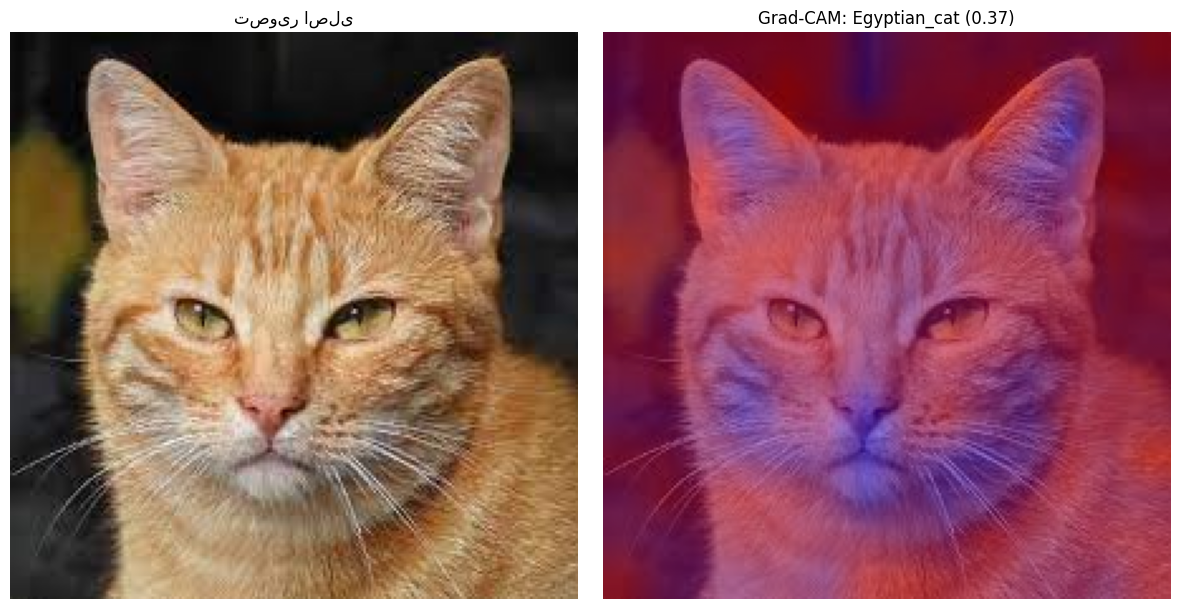

In [ ]:
from captum.attr import LayerGradCam
# تعریف تابع forward برای Grad-CAM
def forward_func(x):
    return model.model(x)  # برگرداندن خروجی مدل

# ایجاد یک شیء LayerGradCam
layer_gc = LayerGradCam(forward_func, model.model.model[-4])

# ایجاد target به شکل مناسب
target = torch.tensor([predicted_class_id])  # ارسال شناسه کلاس به شکل tensor

# اجرای Grad-CAM
attributions = layer_gc.attribute(input_tensor, target=target)

# نرمال‌سازی attributions
attr_min = attributions.min()
attr_max = attributions.max()
attr_normalized = (attributions - attr_min) / (attr_max - attr_min)  # نرمال‌سازی به بازه [0, 1]

# تبدیل به numpy array
attr_normalized = attr_normalized.squeeze().cpu().detach().numpy()

# ایجاد نقشه حرارتی با ترکیب رنگی آبی و قرمز
heatmap = np.zeros((attr_normalized.shape[0], attr_normalized.shape[1], 3), dtype=np.uint8)
heatmap[..., 0] = (255 * attr_normalized).astype(np.uint8)  # کانال آبی برای مقادیر پایین ا
heatmap[..., 1] = np.zeros_like(attr_normalized, dtype=np.uint8)  # کانال سبز به‌عنوان آرایه صفر
heatmap[..., 2] = (255 * (1 - attr_normalized)).astype(np.uint8) #کانال قرمز برای مقادیر بالا

# تغییر اندازه هیت‌مپ به اندازه تصویر اصلی
heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

# ترکیب هیت‌مپ با تصویر اصلی
superimposed_img = cv2.addWeighted(image_rgb, 0.5, heatmap_resized, 0.5, 0)  # ترکیب هیت‌مپ و تصویر اصلی

# نمایش نتایج
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_rgb)
plt.title('تصویر اصلی')
plt.axis('off')

plt.subplot(122)
plt.imshow(superimposed_img / 255)
plt.title(f'Grad-CAM: {class_name} ({confidence:.2f})')
plt.axis('off')

plt.tight_layout()
plt.show()



0: 224x224 golden_retriever 0.56, Labrador_retriever 0.39, Rhodesian_ridgeback 0.01, tennis_ball 0.01, redbone 0.00, 59.7ms
Speed: 0.0ms preprocess, 59.7ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 224)
کلاس پیش‌بینی شده: golden_retriever
اطمینان: 0.56


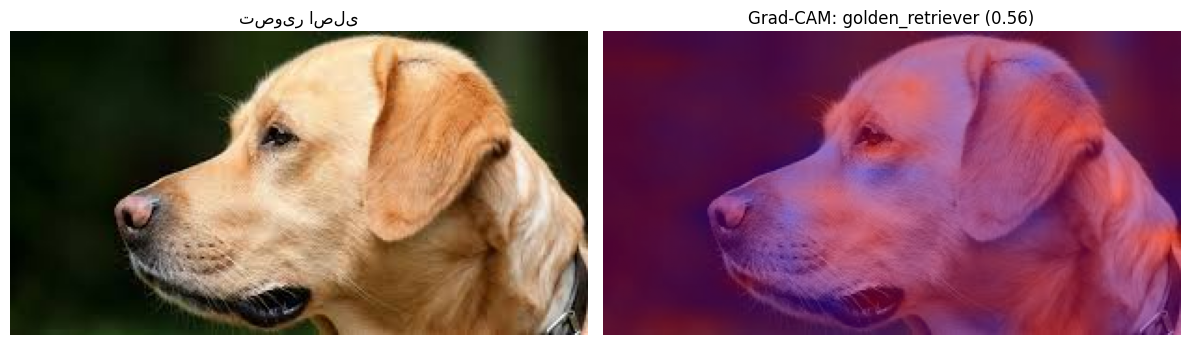

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from ultralytics import YOLO
from captum.attr import LayerGradCam

# بارگذاری مدل از پیش آموزش دیده YOLOv8
model = YOLO('yolov8n-cls.pt')

# اطمینان از اینکه مدل در حالت ارزیابی است
model.model.eval()

# غیرفعال کردن محاسبه گرادیان برای تمام پارامترها
for param in model.model.parameters():
    param.requires_grad = False

# بارگذاری و پیش‌پردازش تصویر
image_path = '/content/dog3.jpg'  # مسیر تصویر خود را اینجا وارد کنید
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Image not found at {image_path}")

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_resized = cv2.resize(image_rgb, (224, 224))
input_tensor = torch.from_numpy(image_resized.transpose(2, 0, 1)).float().unsqueeze(0) / 255.0

# انجام پیش‌بینی
with torch.no_grad():
    results = model(input_tensor)

# دریافت کلاس پیش‌بینی شده
predicted_class_id = int(results[0].probs.top1)  # شناسه کلاس پیش‌بینی شده
class_name = model.names[predicted_class_id]
confidence = results[0].probs.top1conf.item()

print(f"کلاس پیش‌بینی شده: {class_name}")
print(f"اطمینان: {confidence:.2f}")

# تعریف تابع forward برای Grad-CAM
def forward_func(x):
    return model.model(x)  # برگرداندن خروجی مدل

# ایجاد یک شیء LayerGradCam
layer_gc = LayerGradCam(forward_func, model.model.model[-4])

# ایجاد target به شکل مناسب
target = torch.tensor([predicted_class_id])  # ارسال شناسه کلاس به شکل tensor

# اجرای Grad-CAM
attributions = layer_gc.attribute(input_tensor, target=target)

# نرمال‌سازی attributions
attr_min = attributions.min()
attr_max = attributions.max()
attr_normalized = (attributions - attr_min) / (attr_max - attr_min)  # نرمال‌سازی به بازه [0, 1]

# تبدیل به numpy array
attr_normalized = attr_normalized.squeeze().cpu().detach().numpy()

# ایجاد نقشه حرارتی با ترکیب رنگی آبی و قرمز
heatmap = np.zeros((attr_normalized.shape[0], attr_normalized.shape[1], 3), dtype=np.uint8)
heatmap[..., 0] = (255 * attr_normalized).astype(np.uint8)  # کانال آبی برای مقادیر پایین ا
heatmap[..., 1] = np.zeros_like(attr_normalized, dtype=np.uint8)  # کانال سبز به‌عنوان آرایه صفر
heatmap[..., 2] = (255 * (1 - attr_normalized)).astype(np.uint8) #کانال قرمز برای مقادیر بالا

# تغییر اندازه هیت‌مپ به اندازه تصویر اصلی
heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

# ترکیب هیت‌مپ با تصویر اصلی
superimposed_img = cv2.addWeighted(image_rgb, 0.5, heatmap_resized, 0.5, 0)  # ترکیب هیت‌مپ و تصویر اصلی

# نمایش نتایج
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_rgb)
plt.title('تصویر اصلی')
plt.axis('off')

plt.subplot(122)
plt.imshow(superimposed_img / 255)
plt.title(f'Grad-CAM: {class_name} ({confidence:.2f})')
plt.axis('off')

plt.tight_layout()
plt.show()
